## Семинар 2 "Распознавание рукописных цифр"

ФИО: Калашников Дмитрий Павлович

В этом задании мы используем нейронную сеть из предыдущего семинара для распознавания рукописных цифр. Также мы исследуем как влияет выбор нелинейности и предобработка данных на качество классификации. 

Чтобы не тратить время на подготовку данных, мы прилагаем готовый код с примером использования для получения обучающей и тестовой выборок. Для запуска скрипта вам понадобится библиотека PyTorch (инструкции по установке можно найти на сайте <a href="http://pytorch.org">pytorch.org</a>)

In [88]:
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import numpy as np
import sys
from layers import Linear, Sigmoid, NLLLoss, NeuralNetwork # Results from Seminar 1
from IPython.display import clear_output
from skimage.transform import rotate
from torchvision.transforms import RandomAffine
%matplotlib inline

In [4]:
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

--2021-04-20 12:10:44--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Распознаётся www.di.ens.fr (www.di.ens.fr)… 129.199.99.14
Подключение к www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 302 Found
Адрес: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [переход]
--2021-04-20 12:10:44--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Подключение к www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: нет данных [application/x-gzip]
Сохранение в: «MNIST.tar.gz»

MNIST.tar.gz            [              <=>   ]  33,20M  3,51MB/s    за 10s     

2021-04-20 12:10:54 (3,32 MB/s) - «MNIST.tar.gz» сохранён [34813078]

x MNIST/
x MNIST/raw/
x MNIST/raw/train-labels-idx1-ubyte
x MNIST/raw/t10k-labels-idx1-ubyte.gz
x MNIST/raw/t10k-labels-idx1-ubyte
x MNIST/raw/t10k-images-idx3-ubyte.gz
x MNIST/raw/train-images-idx3-ubyte
x MNIST/raw/train-labels-idx1-ubyte.gz
x MN

In [4]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('./', train=True, download=True, transform=transform)
test_dataset = MNIST('./', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [6]:
X, y = next(iter(train_loader))
X = X.numpy()
y = y.numpy()

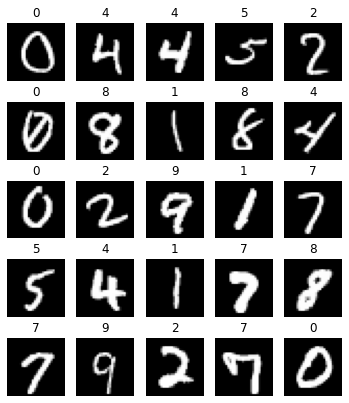

In [7]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

### Часть 1: MNIST
Обучите полносвязную нейронную сеть с архитектурой 784-100-100-10 и сигмоидой в качестве нелинейности. Какую точность классификации удалось получить? Нарисуйте график сходимости на обучающей и тестовой выборках. В качестве темпа обучения (learning rate) возьмите 0.01

In [89]:
def train(network, train_loader, epochs, learning_rate, plot=True,
          verbose=True, loss=None):
    loss = loss or NLLLoss()
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            
            for X, y in train_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                dLdx = loss.backward()
                network.backward(dLdx)
                network.step(learning_rate)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
                
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []    
            
            for X, y in test_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
                
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            clear_output(True)
            
            if verbose:
                sys.stdout.write('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                            epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                            train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
                
            if plot:
                plt.figure(figsize=(12, 5))
                plt.subplot(1, 2, 1)
                plt.plot(train_loss_epochs, label='Train')
                plt.plot(test_loss_epochs, label='Test')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Loss', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.subplot(1, 2, 2)
                plt.plot(train_accuracy_epochs, label='Train accuracy')
                plt.plot(test_accuracy_epochs, label='Test accuracy')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Accuracy', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.show()
                
    except KeyboardInterrupt:
        pass
    
    return train_loss_epochs, \
           test_loss_epochs, \
           train_accuracy_epochs, \
           test_accuracy_epochs

In [9]:
network = NeuralNetwork([
    Linear(784, 100), Sigmoid(), # 28 * 28
    Linear(100, 100), Sigmoid(),
    Linear(100, 10)
])
loss = NLLLoss()

Epoch 19... (Train/Test) NLL: 0.306/0.299	Accuracy: 0.918/0.921

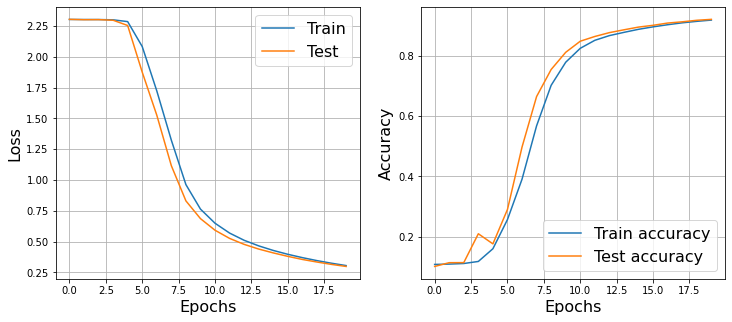

In [10]:
tr_s, ts_s, tr_ac_s, ts_ac_s = train(network,train_loader, 20, 0.01)

### Часть 2: Нелинейности

Обучите нейронную сеть с другими нелинейностями: ReLU и ELU. Сравните скорости сходимости и качество классификации с различными функциями активации.

In [6]:
class ReLU:
    def __init__(self):
        pass

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return np.maximum(X, 0)

    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        return (self.X > 0) * dLdy

    def step(self, learning_rate):
        pass

In [7]:
class ELU:
    '''
    ELU(x) = x, x > 0; a*(e^x - 1), x <= 0
    '''
    
    def __init__(self, a=1):
        self.a = a

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return X * (X > 0) + self.a * (np.exp(X) - 1) * (X <= 0)
    
    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        X = self.X
        dydX = (X > 0) + self.a * np.exp(X) * (X <= 0)
        return dLdy*dydX

    def step(self, learning_rate):
        pass

Epoch 19... (Train/Test) NLL: 0.035/0.083	Accuracy: 0.990/0.976

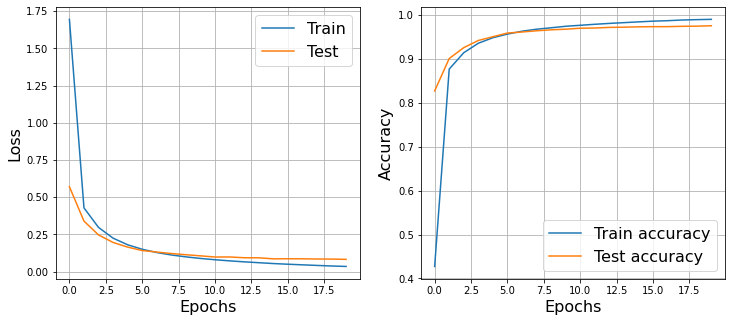

In [13]:
network = NeuralNetwork([
    Linear(784, 100), ReLU(),
    Linear(100, 100), ReLU(),
    Linear(100, 10)
])
loss = NLLLoss()
tr_r, ts_r, tr_ac_r, ts_ac_r = train(network, train_loader, 20, 0.01, plot=True, verbose=True)

Epoch 19... (Train/Test) NLL: 0.047/0.083	Accuracy: 0.987/0.973

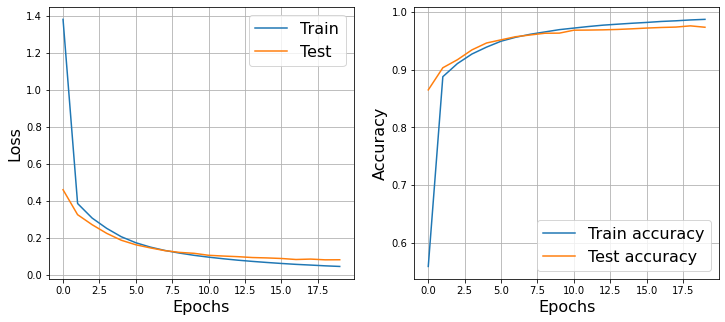

In [14]:
network = NeuralNetwork([Linear(784, 100), ELU(),
               Linear(100, 100), ELU(),
               Linear(100, 10)])
loss = NLLLoss()
tr_e, ts_e, tr_ac_e, ts_ac_e = train(network, train_loader, 20, 0.01, plot=True, verbose=True)

### HW1 (1 балл): Реализовать Tanh

In [8]:
class TanH:
    '''
    TanH(x) = 2 / (1 + e^(-2x)) - 1
    '''
    
    def __init__(self):
        pass

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = 2 / (1 + np.exp(-2 * X)) - 1
        return self.X
    
    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        return dLdy * (1 - self.X ** 2)

    def step(self, learning_rate):
        pass

Epoch 19... (Train/Test) NLL: 0.031/0.073	Accuracy: 0.994/0.978

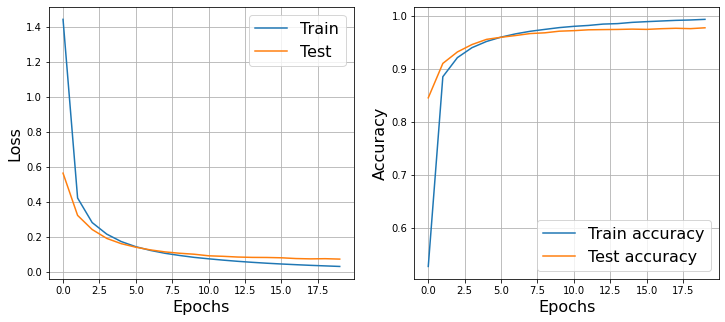

In [23]:
network = NeuralNetwork([Linear(784, 100), TanH(),
               Linear(100, 100), TanH(),
               Linear(100, 10)])
loss = NLLLoss()
tr_t, ts_t, tr_ac_t, ts_ac_t = train(network, train_loader, 20, 0.01, plot=True, verbose=True)

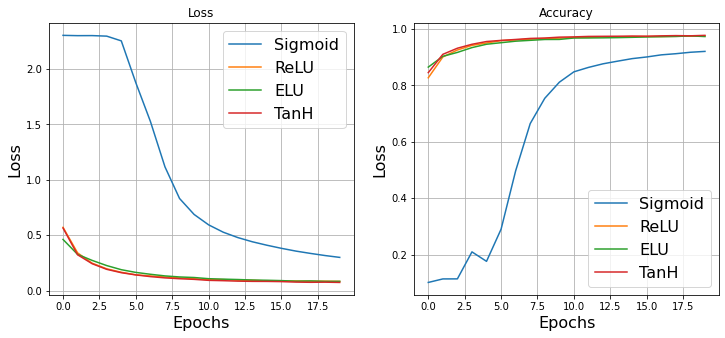

In [24]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')

plt.plot(ts_s, label='Sigmoid')
plt.plot(ts_r, label='ReLU')
plt.plot(ts_e, label='ELU')
plt.plot(ts_t, label='TanH')

plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.subplot(1, 2, 2)
plt.title('Accuracy')

plt.plot(ts_ac_s, label='Sigmoid')
plt.plot(ts_ac_r, label='ReLU')
plt.plot(ts_ac_e, label='ELU')
plt.plot(ts_ac_t, label='TanH')

plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.show()

### Часть 3: Анализ ошибок

In [30]:
wrong_X = []
correct_y = []
predicted_y = []
logits = []

for X, y in test_loader:
    X = X.view(X.shape[0], -1).numpy()
    y = y.numpy()
    prediction = network.forward(X)
    prediction = np.exp(prediction)
    prediction /= prediction.sum(axis=1, keepdims=True)
    
    for i in range(len(prediction)):
        if np.argmax(prediction[i]) != y[i]:
            wrong_X.append(X[i])
            correct_y.append(y[i])
            predicted_y.append(np.argmax(prediction[i]))
            logits.append(prediction[i][y[i]])

wrong_X = np.row_stack(wrong_X)
correct_y = np.row_stack(correct_y)[:, 0]
predicted_y = np.row_stack(predicted_y)[:, 0]
logits = np.row_stack(logits)[:, 0]

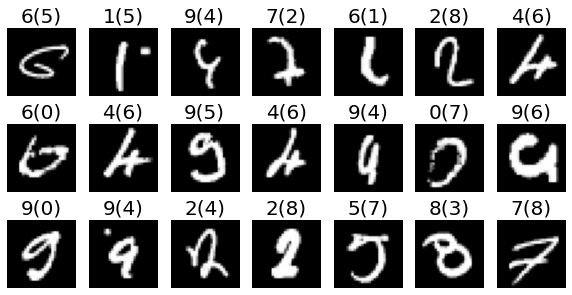

In [31]:
plt.figure(figsize=(10, 5))
order = np.argsort(logits)

for i in range(21):
    plt.subplot(3, 7, i+1)
    plt.imshow(wrong_X[order[i]].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title('{}({})'.format(correct_y[order[i]], predicted_y[order[i]]), fontsize=20)
    plt.axis('off')

### Часть 4: Аугментация (HW, 2 балла)
* Небольшие вращения (-15, 15)
* Случайные сдвиги
* Шум

Какой прирост дают эти аугментации вместе и по отдельности

In [105]:
class AddGaussianNoise(object):
    def __init__(self, mean_part=0, std_part=0.05): # 2 2
        self.mean_part = mean_part
        self.std_part = std_part
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std_part + self.mean_part
        #noise = torch.normal(mean=self.mean_part, std=torch.tensor(self.std_part))
        #return tensor + torch.randn() * noise
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [ ]:
transform0 = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,)),
                    ])

transform1 = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,)),
                        RandomAffine(degrees=15),
                    ])
transform2 = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,)),
                        RandomAffine(degrees=0, translate=(0.1, 0.1)),
                    ])
transform3 = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,)),
                        AddGaussianNoise(),
                    ])
transform4 = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,)),
                        RandomAffine(degrees=15, translate=(0.1, 0.1)),
                        AddGaussianNoise(),
                    ])


train_dataset0 = MNIST('./', train=True, download=True, transform=transform0)
train_dataset1 = MNIST('./', train=True, download=True, transform=transform1)
train_dataset2 = MNIST('./', train=True, download=True, transform=transform2)
train_dataset3 = MNIST('./', train=True, download=True, transform=transform3)
train_dataset4 = MNIST('./', train=True, download=True, transform=transform4)
test_dataset = MNIST('./', train=False, download=True, transform=transform0)

train_loader0 = DataLoader(train_dataset0, batch_size=32, shuffle=True)
train_loader1 = DataLoader(train_dataset1, batch_size=32, shuffle=True)
train_loader2 = DataLoader(train_dataset2, batch_size=32, shuffle=True)
train_loader3 = DataLoader(train_dataset3, batch_size=32, shuffle=True)
train_loader4 = DataLoader(train_dataset4, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [106]:
X, y = next(iter(train_loader1))
X = X.numpy()
y = y.numpy()

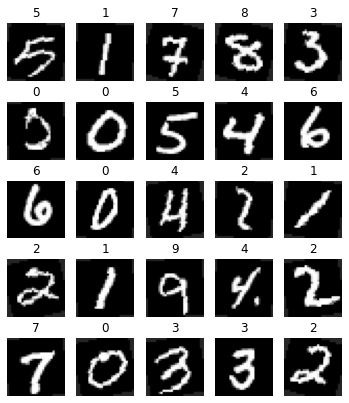

In [107]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

### Without Transform

Epoch 9... (Train/Test) NLL: 0.093/0.102	Accuracy: 0.973/0.969

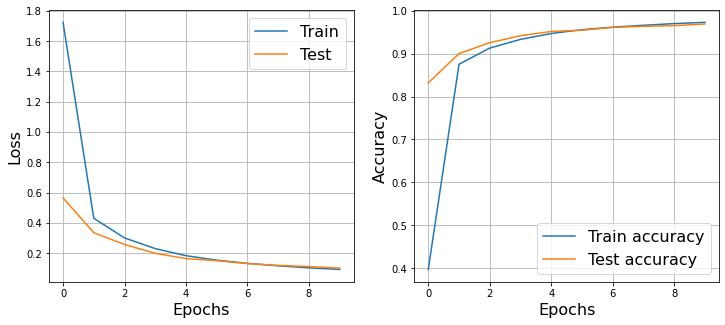

In [109]:
network = NeuralNetwork([
    Linear(784, 100), ReLU(),
    Linear(100, 100), ReLU(),
    Linear(100, 10)
])
loss = NLLLoss()
tr_r, ts_r, tr_ac_r, ts_ac_r = train(network, train_loader0, 10, 0.01, plot=True, verbose=True)

### Rotate

Epoch 9... (Train/Test) NLL: 0.124/0.096	Accuracy: 0.964/0.972

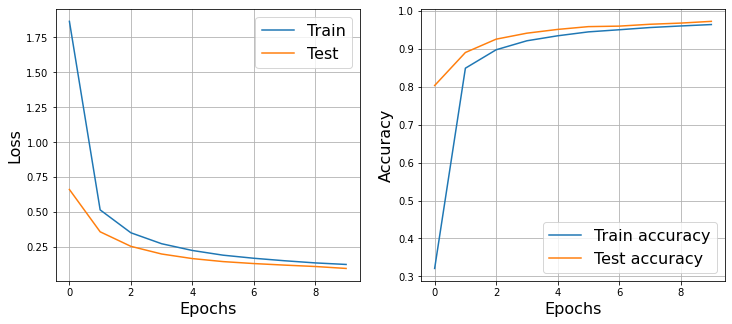

In [108]:
network = NeuralNetwork([
    Linear(784, 100), ReLU(),
    Linear(100, 100), ReLU(),
    Linear(100, 10)
])
loss = NLLLoss()
tr_r, ts_r, tr_ac_r, ts_ac_r = train(network, train_loader1, 10, 0.01, plot=True, verbose=True)

### Shift

Epoch 9... (Train/Test) NLL: 0.176/0.106	Accuracy: 0.947/0.966

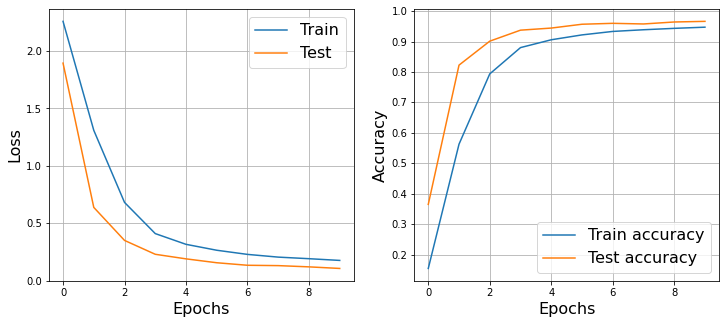

In [111]:
network = NeuralNetwork([
    Linear(784, 100), ReLU(),
    Linear(100, 100), ReLU(),
    Linear(100, 10)
])
loss = NLLLoss()
tr_r, ts_r, tr_ac_r, ts_ac_r = train(network, train_loader2, 10, 0.01, plot=True, verbose=True)

### Noise

Epoch 9... (Train/Test) NLL: 0.096/0.106	Accuracy: 0.972/0.969

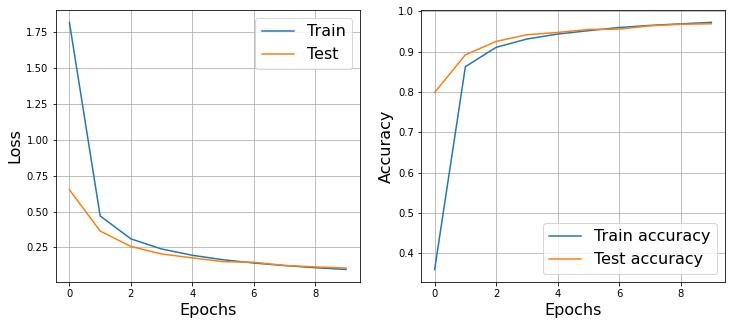

In [112]:
network = NeuralNetwork([
    Linear(784, 100), ReLU(),
    Linear(100, 100), ReLU(),
    Linear(100, 10)
])
loss = NLLLoss()
tr_r, ts_r, tr_ac_r, ts_ac_r = train(network, train_loader3, 10, 0.01, plot=True, verbose=True)

### Rotate + Shift + Noise

Epoch 9... (Train/Test) NLL: 0.217/0.139	Accuracy: 0.934/0.960

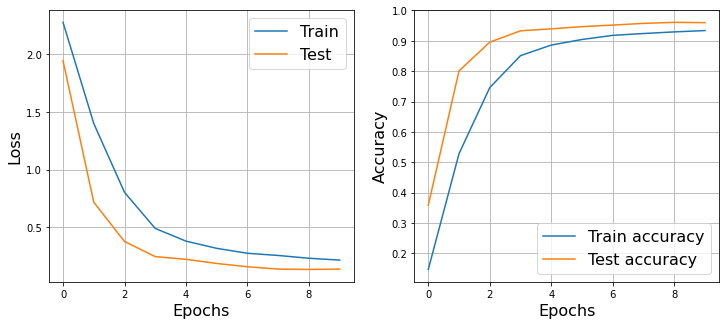

In [113]:
network = NeuralNetwork([
    Linear(784, 100), ReLU(),
    Linear(100, 100), ReLU(),
    Linear(100, 10)
])
loss = NLLLoss()
tr_r, ts_r, tr_ac_r, ts_ac_r = train(network, train_loader4, 10, 0.01, plot=True, verbose=True)

### Часть 5: Выводы
Опишите полученные результаты: как влияют выбор нелинейности и предобработка данных на скорость сходимости и итоговое качество?

При использовании ReLU, ELU и TanH скорость сходимости и качество резко увеличивается по сравнению с Sigmoid. Между собой эти три активации по данным параметрам отличаются несильно в нашей задаче. При аугментации данных качество на тесте сильнее отличается от качества на трейне(в лучшую сторону), скорость сходимости уменьшилась, из-за чего качество на одинаковых параметрах обучения оказалось сравнимо.